In [1]:
# IMPORT PyEMMA
import pyemma
pyemma.__version__


# IMPORT GENERAL PACKAGES
import numpy as np
from IPython import get_ipython
get_ipython().run_line_magic('pylab','')
import pyemma.coordinates as coor
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Select appropriate Features
trajfile = 'JIP1_all_stripped_imaged.nc'
topfile = 'JIP1.prmtop'

feat = coor.featurizer(topfile)

feat.add_backbone_torsions(cossin=True)
feat.describe()[:10]

inp = coor.source(trajfile, feat)
print ('trajectory length = ',inp.trajectory_length(0))
print ('number of dimension = ',inp.dimension())

trajectory length =  200000
number of dimension =  36


In [3]:
# TIME-LAGGED INDEPENDENT COMPONENT ANALYSIS (TICA)
lag=100
tica_obj = coor.tica(inp, lag=lag, var_cutoff=0.95, kinetic_map=False)
# here we get the data that has been projected onto the first 2 IC's. It's a list, because we could generally
# have a list of trajectories, so we just get the first element.
Y = tica_obj.get_output()[0]
tica_output = tica_obj.get_output()

print ('Projected data shape = ',Y.shape)

Projected data shape =  (200000, 11)


In [4]:
#we use k-means clustering and get the discrete trajectories
cl = coor.cluster_kmeans(data=Y, k=250, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

100%|██████████| 250/250 [00:15<00:00, 16.45it/s]                             

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


[3073.42525702 2397.4359998  1178.27317971  958.01817599  625.42764245]


C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


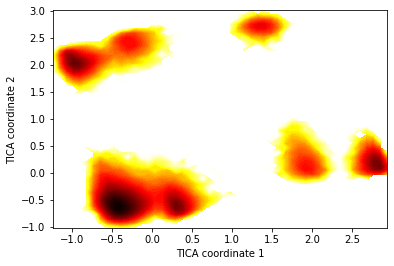

In [5]:
print (-lag/np.log(tica_obj.eigenvalues[:5]))

# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.xlabel('TICA coordinate 1'); plt.ylabel('TICA coordinate 2');
#plt.plot(cc_x,cc_y, linewidth=0, marker='o')

plt.show()


100%|██████████| 250/250 [00:15<00:00, 16.33it/s]                             

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]
C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


[array([ 31,  31, 112, ..., 150, 166, 166])]

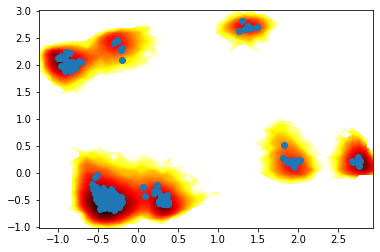

In [6]:
import matplotlib.pyplot as plt
cl = coor.cluster_kmeans(data=Y, k=250, stride=1)
# for later use we save the discrete trajectories and cluster center coordinates:
dtrajs = cl.dtrajs
cc_x = cl.clustercenters[:,0]
cc_y = cl.clustercenters[:,1]

# histogram data
z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]
plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent)
plt.plot(cc_x,cc_y, linewidth=0, marker='o')

cl.dtrajs

In [7]:
for i in range(2):
    if tica_obj.eigenvectors[0, i] > 0:
        tica_obj.eigenvectors[:, i] *= -1

In [8]:
import pyemma.msm as msm
import pyemma.plots as mplt

lags = [10,20,50,100,200]
its = msm.its(dtrajs, lags=lags)


100%|██████████| 5/5 [00:02<00:00,  1.74it/s]                                 


In [9]:
its = pyemma.msm.its(dtrajs, lags=500, nits=10, errors='bayes')


100%|██████████| 16/16 [01:25<00:00,  5.32s/it]                        


26-08-20 16:51:47 pyemma.coordinates.api INFO     Created file ./file_sample/pcca1_100samples.xtc
26-08-20 16:51:48 pyemma.coordinates.api INFO     Created file ./file_sample/pcca2_100samples.xtc
26-08-20 16:51:48 pyemma.coordinates.api INFO     Created file ./file_sample/pcca3_100samples.xtc
26-08-20 16:51:49 pyemma.coordinates.api INFO     Created file ./file_sample/pcca4_100samples.xtc
31033.58257021931
16754.26170093348
percentage Â  Â  Â  	path
-------------------------------------
0.5539550595635138  	 [0 2 1 3]
0.4387571888796346  	 [0 1 3]
0.0072877515568516614  	 [0 2 3]


C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\mahdi\anaconda3\envs\mlapp_v1\lib\site-packages\ipykernel_launcher.py:40: UserWarning: The following kwargs were not used by contour: 'fig'


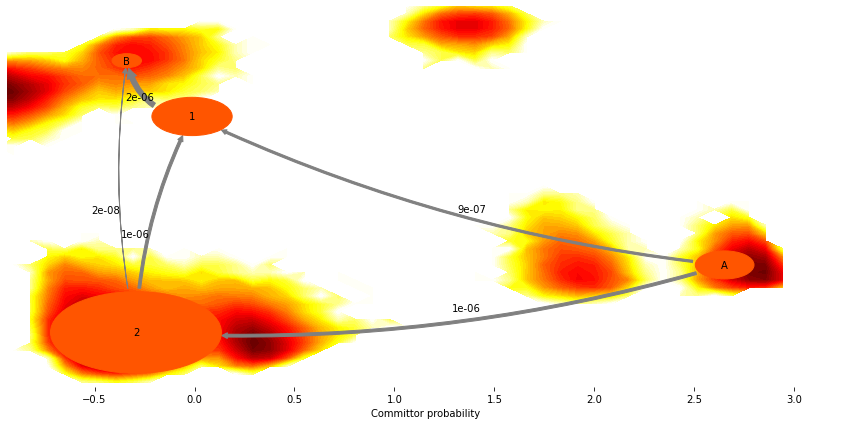

In [12]:
M = msm.estimate_markov_model(dtrajs, 100)
M.pcca(4)
pcca_sets= M.metastable_sets
pcca_dist = M.metastable_distributions


pcca_samples = M.sample_by_distributions(pcca_dist, 2000)
coor.save_traj(inp, pcca_samples[0], './file_sample/pcca1_100samples.xtc')
coor.save_traj(inp, pcca_samples[1], './file_sample/pcca2_100samples.xtc')
coor.save_traj(inp, pcca_samples[2], './file_sample/pcca3_100samples.xtc')
coor.save_traj(inp, pcca_samples[3], './file_sample/pcca4_100samples.xtc')

pcca_samples = M.sample_by_distributions(pcca_dist, 100)

z,x,y = np.histogram2d(Y[:,0],Y[:,1], bins=50)
# compute free energies
F = -np.log(z)

extent = [x[0], x[-1], y[0], y[-1]]

xavg = avg_by_set(cc_x, pcca_sets)
A = pcca_sets[xavg.argmax()]
B = pcca_sets[xavg.argmin()]

fluxAB = msm.tpt(M, A, B)

# mean first passage times in microseconds
print (0.1*M.mfpt(A, B))
print (0.1*M.mfpt(B, A))

cg, cgflux = fluxAB.coarse_grain(pcca_sets)

# compute mean positions of sets. This is important because of some technical points the set order
# in the coarse-grained TPT object can be different from the input order.
avgpos = np.zeros((4,2))
avgpos[:,0] = avg_by_set(cc_x, cg)
avgpos[:,1] = avg_by_set(cc_y, cg)

fig, _ = mplt.plot_flux(cgflux, avgpos, cgflux.stationary_distribution, max_width=10, max_height=7)
cf=plt.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, fig=fig, zorder=0)
fig.set_size_inches(15, 7)

paths, path_fluxes = cgflux.pathways()
print ('percentage Â  Â  Â  \tpath')
print ('-------------------------------------')
for i in range(len(paths)):
    print ((path_fluxes[i] / np.sum(path_fluxes)),' \t', paths[i])